# Conclusion:
There are no lines coincident with NaCl.  This is a line-poor source with nothing to stack up on.  CH3CN and other common species are prominently detected.  There's something fairly unique and interesting going on here, but not salt.

References:
 * https://ui.adsabs.harvard.edu/abs/2020ApJ...888...41A/abstract - modeling accretion disk

In [1]:
cd /orange/adamginsburg/salt/sanhueza/IRAS18162

/orange/adamginsburg/salt/sanhueza/IRAS18162


In [2]:
ls

cutout2.reg
cutout.reg
I18192_Sanhueza_NaCl_PV_withcolorcurves.png
I18192_Sanhueza_SO_PV_withcolorcurves.png
I18192_Sanhueza_Water_PV_withcolorcurves.png
IRAS_181622048.config8.cont_avg.selfcal_0.5_hogbom.image.fits
IRAS_181622048.config8.spw0.robust0.5.image_co1_smaller.fits
IRAS_181622048.config8.spw0.robust0.5.image_co3_smaller.fits
IRAS_181622048.config8.spw0.robust0.5.image_small.fits
IRAS_181622048.config8.spw1.robust0.5.image_co1_smaller.fits
IRAS_181622048.config8.spw1.robust0.5.image_co3_smaller.fits
IRAS_181622048.config8.spw1.robust0.5.image_small.fits
IRAS_181622048.config8.spw2.robust0.5.image_co1_smaller.fits
IRAS_181622048.config8.spw2.robust0.5.image_co3_smaller.fits
IRAS_181622048.config8.spw2.robust0.5.image_small.fits
IRAS_181622048.config8.spw3.robust0.5.image_co1_smaller.fits
IRAS_181622048.config8.spw3.robust0.5.image_co3_smaller.fits
IRAS_181622048.config8.spw3.robust0.5.image_small.fits
NaCl_v_le_3_stackcube.fits
spectra/


In [3]:
targetname = 'IRAS_181622048'

for fn in glob.glob("*.fits"):
    print('app

In [4]:
%matplotlib inline
import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
pl.rcParams['image.origin'] = 'lower'
pl.rcParams['font.size'] = 16
from spectral_cube import SpectralCube
from astropy import units as u
from astropy.visualization import quantity_support
quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x2b68eeaffeb0>

In [5]:
from astropy.table import Table
from astropy import table

In [6]:
import pprint

In [7]:
import scipy, scipy.ndimage

In [8]:
import numpy as np
import os
import glob
from astropy import constants, units as u, table, stats, coordinates, wcs, log, coordinates as coord
import radio_beam
import pyspeckit
import pylab as pl
from astroquery.splatalogue.utils import minimize_table as mt
import sys
sys.path.append('/orange/adamginsburg/salt/Orion_ALMA_2016.1.00165.S/analysis')
import lines
import paths
from salt_tables import (salt_tables, salt_table_names, SO, SO2, HCl, sis_tables, AlCl, AlF, Al37Cl,
                         NaF, AlO, AlOH, NaCN, CaS, CaO)

In [9]:
import sys
sys.path.append('/orange/adamginsburg/salt/Orion_ALMA_2016.1.00165.S/analysis')
from show_pv import show_pv
import imp
import show_pv
imp.reload(show_pv)
from show_pv import show_keplercurves, show_pv

In [10]:
import regions
from astropy import units as u, coordinates
reg = regions.Regions.read('cutout.reg')
#reg2 = regions.Regions.read('cutout2.reg')
#reg3 = regions.Regions.read('cutout3.reg')
#regvsm = regions.Regions.read('verysmall.reg')
#regvvsm = regions.Regions.read('innerdiskbox.reg')

In [11]:
reg[0].center.galactic

<SkyCoord (Galactic): (l, b) in deg
    (10.8413657, -2.59164061)>

# NaCl Stackl

In [12]:
from spectral_cube.analysis_utilities import stack_cube

In [13]:
nacltables = salt_tables[3:5]
#nacltables[0]

In [14]:
import spectral_cube.analysis_utilities
import imp
imp.reload(spectral_cube.analysis_utilities)
from spectral_cube.analysis_utilities import stack_cube

In [15]:
flist = (glob.glob(f'{targetname}.config8.spw[0-3].robust0.5.image_small.fits'))

In [16]:
flist

['IRAS_181622048.config8.spw3.robust0.5.image_small.fits',
 'IRAS_181622048.config8.spw1.robust0.5.image_small.fits',
 'IRAS_181622048.config8.spw2.robust0.5.image_small.fits',
 'IRAS_181622048.config8.spw0.robust0.5.image_small.fits']

In [17]:
#from dask.diagnostics import ProgressBar
#pbar = ProgressBar()
#pbar.register()

import dask
dask.config.set(scheduler='threads', num_workers=8)

In [18]:
for fn in flist:
    for rr,regn in ( (reg, 'co1'), ):
        outfile = fn.replace("_small",f"_{regn}_smaller")
        if not os.path.exists(outfile):
            cube = SpectralCube.read(fn, use_dask=False).subcube_from_regions(rr)
            cube.allow_huge_operations=True
            #with cube.use_dask_scheduler('threads', num_workers=8):
            cb = cube.beams.common_beam(max_iter=20, max_epsilon=0.01)
            scube = cube.convolve_to(cb).to(u.K)
            scube.write(outfile, overwrite=True)

In [19]:
regn = "co1"
# don't need to subcube b/c reg = cutout = co1
cubes = [SpectralCube.read(fn, use_dask=True)#.subcube_from_regions(reg3)
         for fn in (glob.glob(f'{targetname}.config8.spw[0-3].robust0.5.image_{regn}_smaller.fits'))]
for ii,cube in enumerate(cubes):
    # continuum subtract
    with cube.use_dask_scheduler('threads', num_workers=8):
        cube.allow_huge_operations = True
        cubes[ii] = cube - cube.percentile(25, axis=0)
cubes

[DaskSpectralCube with shape=(3860, 159, 173) and unit=K and chunk size (386, 159, 173):
  n_x:    173  type_x: RA---SIN  unit_x: deg    range:   274.800125 deg:  274.800636 deg
  n_y:    159  type_y: DEC--SIN  unit_y: deg    range:   -20.792144 deg:  -20.791706 deg
  n_s:   3860  type_s: FREQ      unit_s: Hz     range: 216862707361.400 Hz:218747086033.577 Hz,
 DaskSpectralCube with shape=(1930, 159, 173) and unit=K and chunk size (386, 159, 173):
  n_x:    173  type_x: RA---SIN  unit_x: deg    range:   274.800125 deg:  274.800636 deg
  n_y:    159  type_y: DEC--SIN  unit_y: deg    range:   -20.792144 deg:  -20.791706 deg
  n_s:   1930  type_s: FREQ      unit_s: Hz     range: 231062952403.500 Hz:232946842768.170 Hz,
 DaskSpectralCube with shape=(1931, 159, 173) and unit=K and chunk size (609, 159, 173):
  n_x:    173  type_x: RA---SIN  unit_x: deg    range:   274.800125 deg:  274.800636 deg
  n_y:    159  type_y: DEC--SIN  unit_y: deg    range:   -20.792144 deg:  -20.791706 deg
  n_s: 

In [20]:
# only needed for VRSCs
if hasattr(cubes[0], 'beams'):
    beams = radio_beam.Beams(beams=[cube.beams.common_beam(max_iter=20, max_epsilon=0.01) for cube in cubes])
    cb=beams.common_beam()
else:
    beams = radio_beam.Beams(beams=[cube.beam for cube in cubes])
    cb=beams.common_beam()
jtok = cb.jtok(217*u.GHz)

In [21]:
linelist = np.concatenate([data['Freq'][(data['vu'] <= 3) &
                                          np.any([((data['Freq'].quantity > cube.spectral_extrema[0]) &
                                                   (data['Freq'].quantity < cube.spectral_extrema[1]))
                                                 for cube in cubes],
                                                 axis=0)].quantity
                             for data in nacltables])
linenames = np.concatenate( [data['Species'][(data['vu'] <= 3) &
                                          np.any([((data['Freq'].quantity > cube.spectral_extrema[0]) &
                                                   (data['Freq'].quantity < cube.spectral_extrema[1]))
                                                 for cube in cubes],
                                                 axis=0)]
                             for data in nacltables] )
(linelist, linenames)

(<Quantity [217.980231, 219.614936, 232.509977, 234.251912] GHz>,
 array(['23Na-35Clv=2-2 J=17-16', '23Na-35Clv=1-1 J=17-16',
        '23Na-35Clv=1-1 J=18-17', '23Na-35Clv=0-0 J=18-17'], dtype='<U24'))

In [22]:
from astropy import log
log.setLevel('INFO')

In [23]:
vcen = 14.5 * u.km/u.s # from Patricio
vcen = 11.8*u.km/u.s # Manuel Fernandez+ : https://arxiv.org/pdf/1107.3176.pdf
vcen = 12.5*u.km/u.s # Anez-Lopez

In [24]:
#log.setLevel('DEBUG')
stack, cutouts = stack_cube(cubes,
                   linelist=linelist,
                   vmin=vcen-25*u.km/u.s,
                   vmax=vcen+25*u.km/u.s,
                   average=np.nanmean,
                   convolve_beam=cb,
                   return_cutouts=True)
#log.setLevel('INFO')
stack.write('NaCl_v_le_3_stackcube.fits', overwrite=True)

In [25]:
stackc = SpectralCube.read('NaCl_v_le_3_stackcube.fits')
stackc

SpectralCube with shape=(75, 159, 173) and unit=K:
 n_x:    173  type_x: RA---SIN  unit_x: deg    range:   274.800125 deg:  274.800636 deg
 n_y:    159  type_y: DEC--SIN  unit_y: deg    range:   -20.792144 deg:  -20.791706 deg
 n_s:     75  type_s: VRAD      unit_s: km / s  range:      -12.380 km / s:      37.317 km / s

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


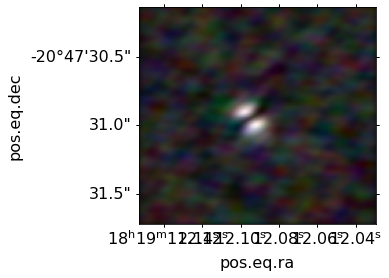

In [26]:
m0b = stackc.spectral_slab(vcen-15*u.km/u.s, vcen-5*u.km/u.s).moment0()
m0g = stackc.spectral_slab(vcen-5*u.km/u.s, vcen+5*u.km/u.s).moment0()
m0r = stackc.spectral_slab(vcen+5*u.km/u.s, vcen+15*u.km/u.s).moment0()
ax = pl.subplot(projection=m0b.wcs.celestial)
rgb = np.array([m0r.value, m0g.value, m0b.value]).swapaxes(0,2).swapaxes(0,1)
rgb /= rgb.max()
ax.imshow(rgb, origin='lower')

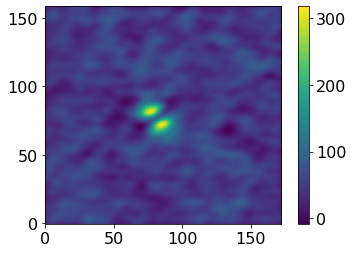

In [27]:
m0r.quicklook()
pl.colorbar()

In [28]:
cont = SpectralCube.read('IRAS_181622048.config8.cont_avg.selfcal_0.5_hogbom.image.fits').to(u.K)
cont

SpectralCube with shape=(1, 5120, 5120) and unit=K:
 n_x:   5120  type_x: RA---SIN  unit_x: deg    range:   274.793222 deg:  274.808433 deg
 n_y:   5120  type_y: DEC--SIN  unit_y: deg    range:   -20.798505 deg:  -20.784286 deg
 n_s:      1  type_s: FREQ      unit_s: Hz     range: 226150027987.200 Hz:226150027987.200 Hz

In [29]:
yc,xc = np.unravel_index(np.nanargmax(cont[0]), cont[0].shape)

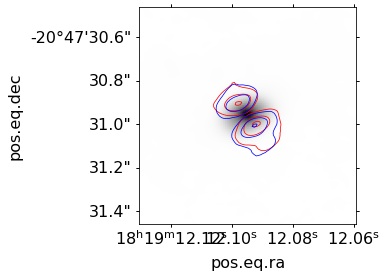

In [30]:
fig = pl.figure()
fig.add_subplot(projection=cont.wcs.celestial)
ax = fig.gca()
ax.imshow(cont[0].value, cmap='gray_r')
#ax.axis((2460,2550,2530,2610))
ax.axis((xc-50,xc+50,yc-50,yc+50))
ax.contour(m0r, colors=['r']*5, levels=[100,200,300], linewidths=[0.75]*5, transform=ax.get_transform(m0r.wcs.celestial))
ax.contour(m0b, colors=['b']*5, levels=[100,200,300], linewidths=[0.75]*5, transform=ax.get_transform(m0b.wcs.celestial))

DaskSpectralCube with shape=(1930, 159, 173) and unit=K and chunk size (386, 159, 173):
 n_x:    173  type_x: RA---SIN  unit_x: deg    range:   274.800125 deg:  274.800636 deg
 n_y:    159  type_y: DEC--SIN  unit_y: deg    range:   -20.792144 deg:  -20.791706 deg
 n_s:   1930  type_s: FREQ      unit_s: Hz     range: 231062952403.500 Hz:232946842768.170 Hz
DaskSpectralCube with shape=(33, 159, 173) and unit=K and chunk size (33, 159, 173):
 n_x:    173  type_x: RA---SIN  unit_x: deg    range:   274.800125 deg:  274.800636 deg
 n_y:    159  type_y: DEC--SIN  unit_y: deg    range:   -20.792144 deg:  -20.791706 deg
 n_s:     33  type_s: VRAD      unit_s: km / s  range:       -8.018 km / s:      32.247 km / s


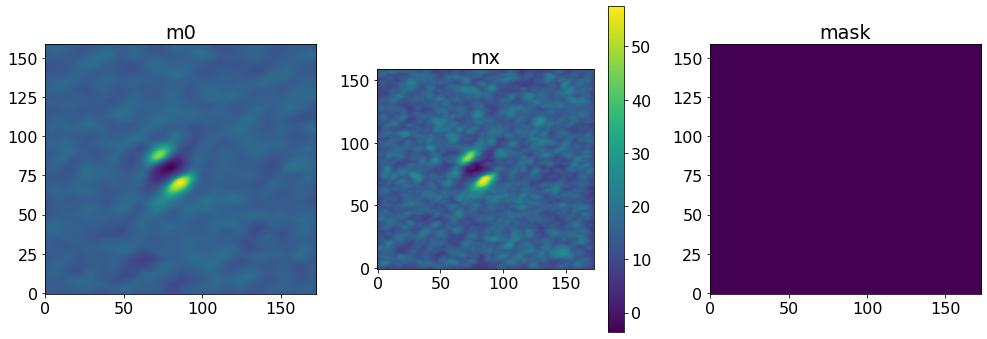

<Figure size 432x288 with 0 Axes>

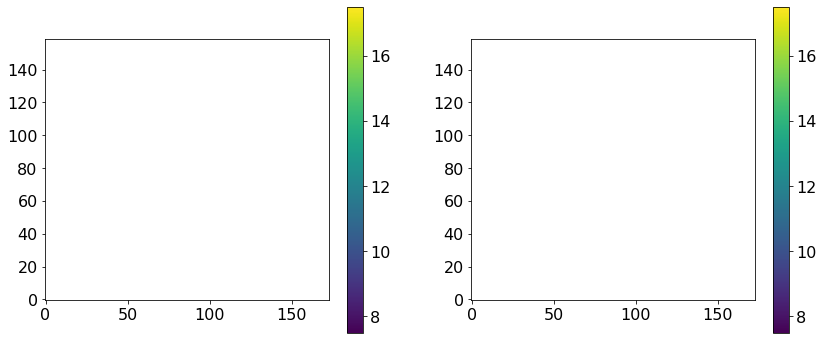

In [31]:
# try creating a vmap based on another line (water)
restval = 232.6867*u.GHz # 'H2Ov2=1_5(5,0)-6(4,3)': 
cube = [c for c in cubes if (c.spectral_extrema[0] < restval) & (c.spectral_extrema[1] > restval)][0]
print(cube)
watercube = scube = (cube.subcube_from_regions(reg)
         .with_spectral_unit(u.km/u.s,
                                                          velocity_convention='radio',
                                                          rest_value=restval)
         .spectral_slab(-20*u.km/u.s+vcen, 20*u.km/u.s+vcen))
print(scube)
pl.figure(figsize=(14,5))
pl.subplot(1,3,1)
m0 = scube.moment0()
m0.quicklook()
pl.title("m0")

pl.subplot(1,3,2)
mx = scube.max(axis=0)
mx.quicklook()
pl.title("mx")
pl.colorbar()
pl.subplot(1,3,3)
msk = mx > 0.04*jtok
#msk = scipy.ndimage.binary_erosion(msk, iterations=1)
msk = scipy.ndimage.binary_dilation(msk, iterations=14)
pl.imshow(msk, interpolation='none', origin='lower')
pl.title('mask')
pl.tight_layout()
pl.figure()


m1 = scube.with_mask(msk).with_mask(scube > 20*u.K).moment1()
pl.figure(figsize=(14,6))
ax1 = pl.subplot(1,2,1)
im = ax1.imshow(m1.value, vmin=vcen.value-5, vmax=vcen.value+5)
pl.colorbar(mappable=im)
mxv = scube.with_mask(msk).argmax_world(axis=0)
pl.subplot(1,2,2)
pl.imshow(mxv.value, vmin=vcen.value-5, vmax=vcen.value+5)
pl.colorbar()


#vmap = m1.hdu
# the rest value selected above was just the line center; we need to assume it's really 32 km/s off
#vmap.data = vmap.data

In [32]:
import pvextractor
center = coordinates.SkyCoord('18h19m12.0955s', '-20:47:30.948', unit=u.deg, frame='icrs')
PA = 113*u.deg
path = pvextractor.Path(coordinates.SkyCoord([center.directional_offset_by(PA, 1.5*u.arcsec), center.directional_offset_by(180*u.deg+PA, 1.5*u.arcsec)]))

In [33]:
pvd_water = pvextractor.extract_pv_slice(watercube, path)

leftmost: 0.00017500000000001398 arcsec
rightmost: 0.000691666666666722 arcsec
endpoints_x = [1.705175   1.74088929] arcsec


divide by zero encountered in true_divide
divide by zero encountered in true_divide
divide by zero encountered in true_divide


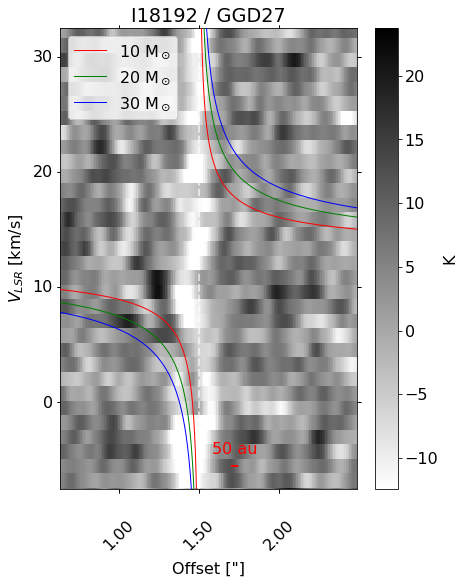

In [34]:
fig,ax,cb,con = show_pv(pvd_water.data, wcs.WCS(pvd_water.header), origin=1.5*u.arcsec, #coordinates.SkyCoord('18:22:26.3857', '-13:30:11.979', unit=(u.hour, u.deg), frame='icrs'),
                vrange=np.array([vcen.value-20, vcen.value+20]), vcen=vcen,
                        imvmin=np.nanpercentile(pvd_water.data, 3), imvmax=np.nanmax(pvd_water.data),
                        distance=1.4*u.kpc,
                        xoffset_label=1.705*u.arcsec
                    )
cb.set_label("K")
kc = show_keplercurves(ax, 1.5*u.arcsec, 1500*u.au, 
                       vcen=vcen,
                               masses=[10,20,30,],
                               linestyles=['-']*4,
                               colors=['r','g','b','c'],
                       radii={},
                       distance=1.4*u.kpc,
                              )
pl.legend(loc='upper left')

pl.title("I18192 / GGD27")
pl.savefig("I18192_Sanhueza_Water_PV_withcolorcurves.png")
#pl.legend(loc='best')

DaskSpectralCube with shape=(3860, 159, 173) and unit=K and chunk size (386, 159, 173):
 n_x:    173  type_x: RA---SIN  unit_x: deg    range:   274.800125 deg:  274.800636 deg
 n_y:    159  type_y: DEC--SIN  unit_y: deg    range:   -20.792144 deg:  -20.791706 deg
 n_s:   3860  type_s: FREQ      unit_s: Hz     range: 219062707499.000 Hz:220947086171.413 Hz
DaskSpectralCube with shape=(61, 159, 173) and unit=K and chunk size (61, 159, 173):
 n_x:    173  type_x: RA---SIN  unit_x: deg    range:   274.800125 deg:  274.800636 deg
 n_y:    159  type_y: DEC--SIN  unit_y: deg    range:   -20.792144 deg:  -20.791706 deg
 n_s:     61  type_s: VRAD      unit_s: km / s  range:       -7.367 km / s:      32.566 km / s


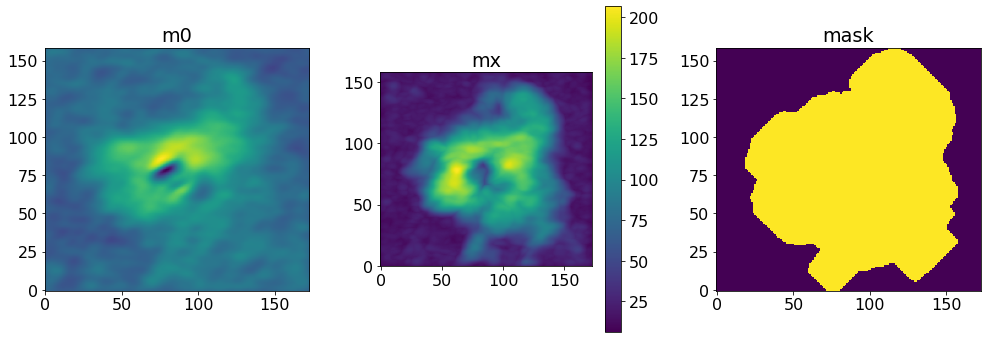

<Figure size 432x288 with 0 Axes>

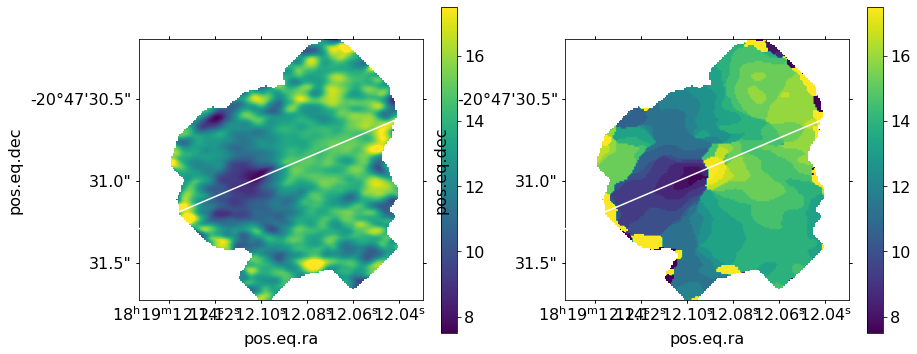

In [35]:
# try creating a vmap based on another line (SO 65-54)
restval = 219.94944000*u.GHz # '': 
cube = [c for c in cubes if (c.spectral_extrema[0] < restval) & (c.spectral_extrema[1] > restval)][0]
print(cube)
socube = scube = (cube.subcube_from_regions(reg)
         .with_spectral_unit(u.km/u.s,
                             velocity_convention='radio',
                             rest_value=restval)
         .spectral_slab(-20*u.km/u.s+vcen, 20*u.km/u.s+vcen))
print(scube)
pl.figure(figsize=(14,5))
pl.subplot(1,3,1)
m0 = scube.moment0()
m0.quicklook()
pl.title("m0")

pl.subplot(1,3,2)
mx = scube.max(axis=0)
mx.quicklook()
pl.title("mx")
pl.colorbar()
pl.subplot(1,3,3)
msk = mx > 0.022*jtok
#msk = scipy.ndimage.binary_erosion(msk, iterations=1)
msk = scipy.ndimage.binary_dilation(msk, iterations=14)
pl.imshow(msk, interpolation='none', origin='lower')
pl.title('mask')
pl.tight_layout()
pl.figure()


m1 = scube.with_mask(msk).with_mask(scube > 0.0001*jtok).moment1()
pl.figure(figsize=(14,6))
ax1 = pl.subplot(1,2,1, projection=scube.wcs.celestial)
im = ax1.imshow(m1.value, vmin=vcen.value-5, vmax=vcen.value+5)
pl.colorbar(mappable=im)
mxv = scube.with_mask(msk).argmax_world(axis=0)
ax2 = pl.subplot(1,2,2, projection=scube.wcs.celestial)
pl.imshow(mxv.value, vmin=vcen.value-5, vmax=vcen.value+5)
pl.colorbar()
path.show_on_axis(ax1, spacing=1, color='w')
path.show_on_axis(ax2, spacing=1, color='w')


vmap = m1.hdu

In [36]:
pvd_SO = pvextractor.extract_pv_slice(socube, path)

leftmost: 0.00017500000000001398 arcsec
rightmost: 0.000691666666666722 arcsec
endpoints_x = [1.705175   1.74088929] arcsec


divide by zero encountered in true_divide
divide by zero encountered in true_divide
divide by zero encountered in true_divide


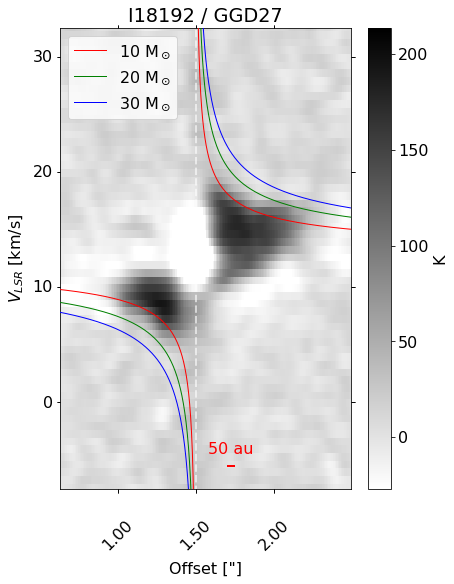

In [37]:
fig,ax,cb,con = show_pv(pvd_SO.data, wcs.WCS(pvd_SO.header), origin=1.5*u.arcsec, #coordinates.SkyCoord('18:22:26.3857', '-13:30:11.979', unit=(u.hour, u.deg), frame='icrs'),
                vrange=np.array([vcen.value-20, vcen.value+20]), vcen=vcen, imvmin=np.nanpercentile(pvd_SO.data, 3), imvmax=np.nanmax(pvd_SO.data),
                        distance=1.4*u.kpc,
                        xoffset_label=1.705*u.arcsec
                    )
cb.set_label("K")
kc = show_keplercurves(ax, 1.5*u.arcsec, 1500*u.au, 
                       vcen=vcen,
                               masses=[10,20,30,],
                               linestyles=['-']*4,
                               colors=['r','g','b','c'],
                       radii={},
                       distance=1.4*u.kpc,
                              )
pl.legend(loc='upper left')

pl.title("I18192 / GGD27")
pl.savefig("I18192_Sanhueza_SO_PV_withcolorcurves.png")
#pl.legend(loc='best')

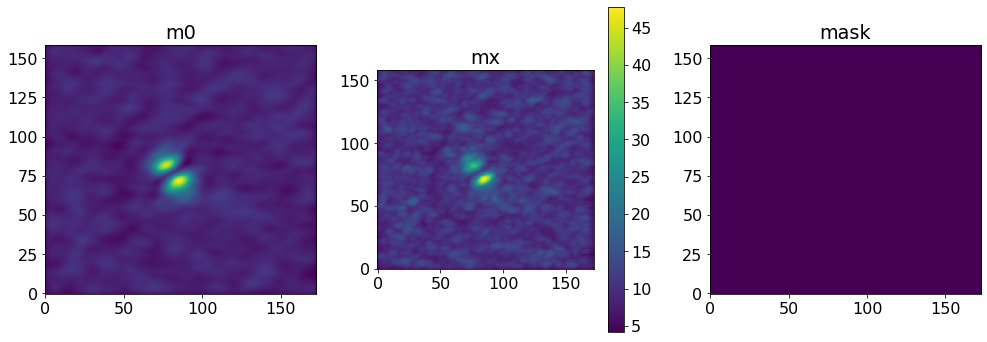

<Figure size 432x288 with 0 Axes>

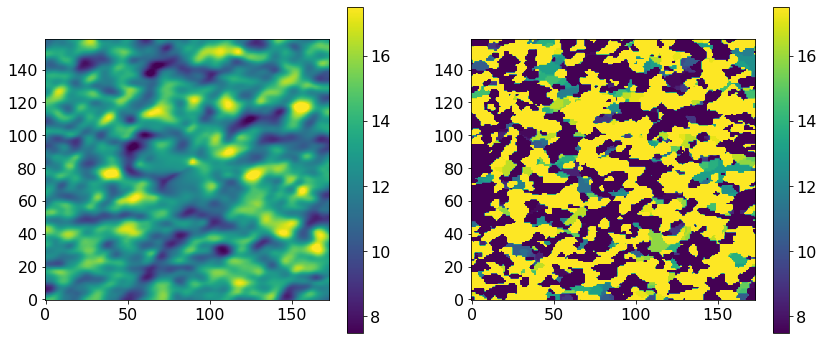

In [38]:
stackc = stackc.subcube_from_regions(reg)
pl.figure(figsize=(14,5))
pl.subplot(1,3,1)
m0 = stackc.moment0()
m0.quicklook()
pl.title("m0")

pl.subplot(1,3,2)
mx = stackc.max(axis=0)
mx.quicklook()
pl.title("mx")
pl.colorbar()
pl.subplot(1,3,3)
msk = mx > 0.0115*mx.unit
msk = scipy.ndimage.binary_erosion(msk, iterations=1)
msk = scipy.ndimage.binary_dilation(msk, iterations=15)
pl.imshow(msk, interpolation='none', origin='lower')
pl.title('mask')
pl.tight_layout()
pl.figure()


m1 = stackc.with_mask(msk).with_mask(stackc > 0.0001*stackc.unit).moment1()
pl.figure(figsize=(14,6))
ax1 = pl.subplot(1,2,1)
im = ax1.imshow(m1.value, vmin=vcen.value-5, vmax=vcen.value+5)
pl.colorbar(mappable=im)
mxv = stackc.with_mask(msk).argmax_world(axis=0)
pl.subplot(1,2,2)
pl.imshow(mxv.value, vmin=vcen.value-5, vmax=vcen.value+5)
pl.colorbar()


#vmap = m1.hdu

leftmost: 0.00017500000000001398 arcsec
rightmost: 0.000691666666666722 arcsec
endpoints_x = [1.705175   1.74088929] arcsec


divide by zero encountered in true_divide
divide by zero encountered in true_divide
divide by zero encountered in true_divide


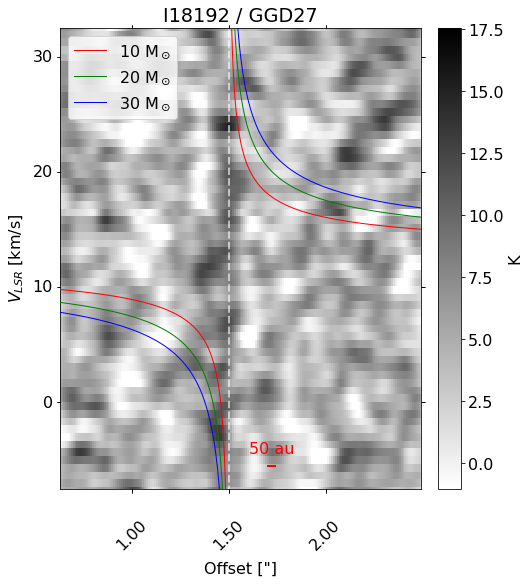

In [39]:
pvd_nacl = pvextractor.extract_pv_slice(stackc, path)

fig,ax,cb,con = show_pv(pvd_nacl.data, wcs.WCS(pvd_nacl.header), origin=1.5*u.arcsec, #coordinates.SkyCoord('18:22:26.3857', '-13:30:11.979', unit=(u.hour, u.deg), frame='icrs'),
                vrange=np.array([vcen.value-20, vcen.value+20]), vcen=vcen, imvmin=np.nanpercentile(pvd_nacl.data, 3), imvmax=np.nanmax(pvd_nacl.data),
                        distance=1.4*u.kpc,
                        xoffset_label=1.705*u.arcsec
                    )
cb.set_label("K")
kc = show_keplercurves(ax, 1.5*u.arcsec, 1500*u.au, 
                       vcen=vcen,
                               masses=[10,20,30,],
                               linestyles=['-']*4,
                               colors=['r','g','b','c'],
                       radii={},
                       distance=1.4*u.kpc,
                              )
pl.legend(loc='upper left')

pl.title("I18192 / GGD27")
pl.savefig("I18192_Sanhueza_NaCl_PV_withcolorcurves.png")
#pl.legend(loc='best')

In [40]:
import sys
sys.path.append('/orange/adamginsburg/salt/code/')
from overplot_saltlines import overplot_saltlines

In [41]:
spectra = []
for ii,cube in enumerate(cubes):
    cube.allow_huge_operations=True
    sp = cube.subcube_from_regions(reg).mean(axis=(1,2))
    pysp = pyspeckit.Spectrum(data=sp, xarr=sp.spectral_axis, header=sp.header)
    spectra.append(pysp)
    pysp.specname = f'spw{ii+1}'

In [42]:
mkdir -p spectra/figures

spw1
spw2
spw3
spw4


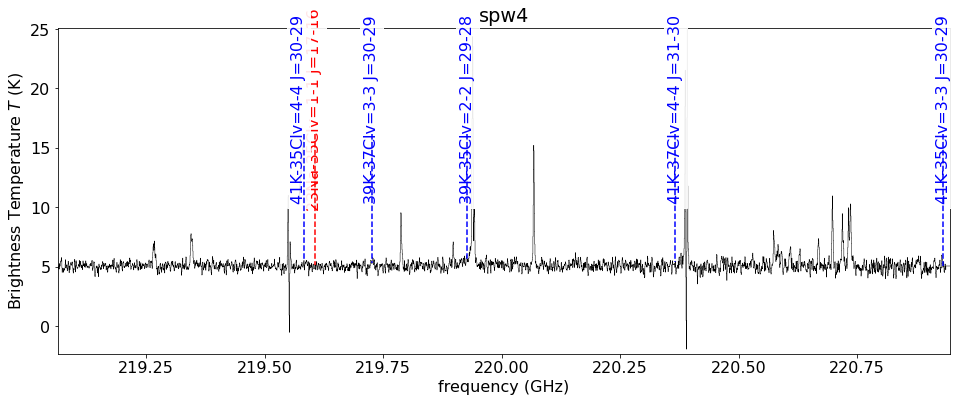

In [43]:
overplot_saltlines(spectra, vcen=vcen, savepath='spectra/figures')

In [44]:
ls spectra/figures

color_labels_IRAS_181622048_5_stack.png
color_labels_spw1.png
color_labels_spw2.png
color_labels_spw3.png
color_labels_spw4.png
IRAS_181622048_5_stack.png
IRAS_181622048.config8.spw0.robust0.5.image_co1_smaller_stack.pdf
IRAS_181622048.config8.spw0.robust0.5.image_co1_smaller_stack.png
IRAS_181622048.config8.spw1.robust0.5.image_co1_smaller_stack.pdf
IRAS_181622048.config8.spw1.robust0.5.image_co1_smaller_stack.png
IRAS_181622048.config8.spw2.robust0.5.image_co1_smaller_stack.pdf
IRAS_181622048.config8.spw2.robust0.5.image_co1_smaller_stack.png
IRAS_181622048.config8.spw3.robust0.5.image_co1_smaller_stack.pdf
IRAS_181622048.config8.spw3.robust0.5.image_co1_smaller_stack.png
spw1.png
spw2.png
spw3.png
spw4.png


In [45]:
from IPython.display import Image,display

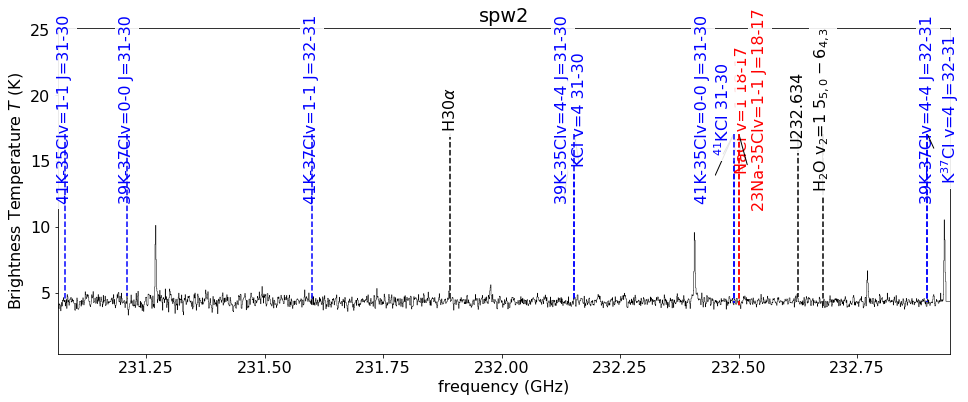

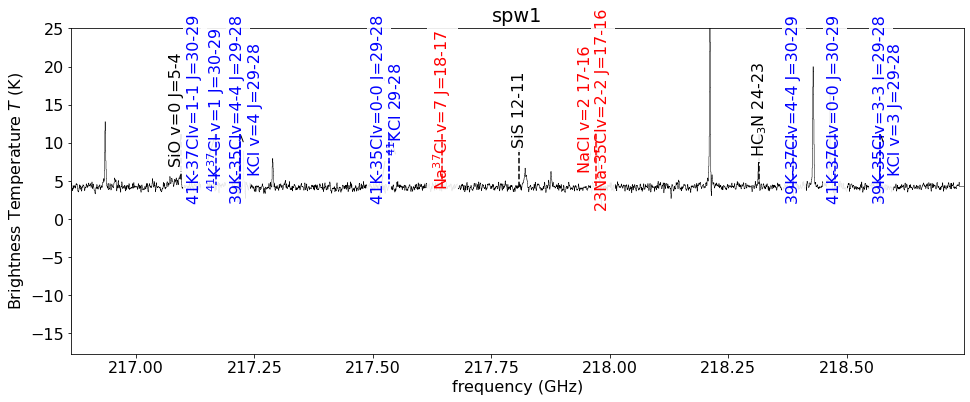

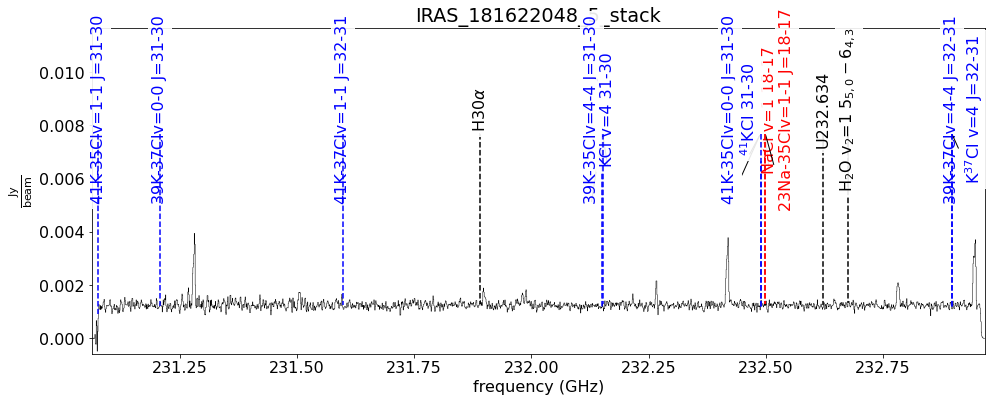

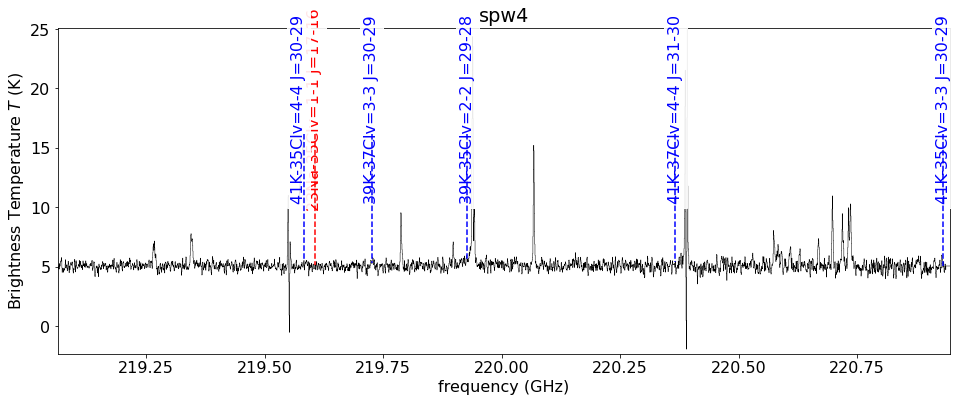

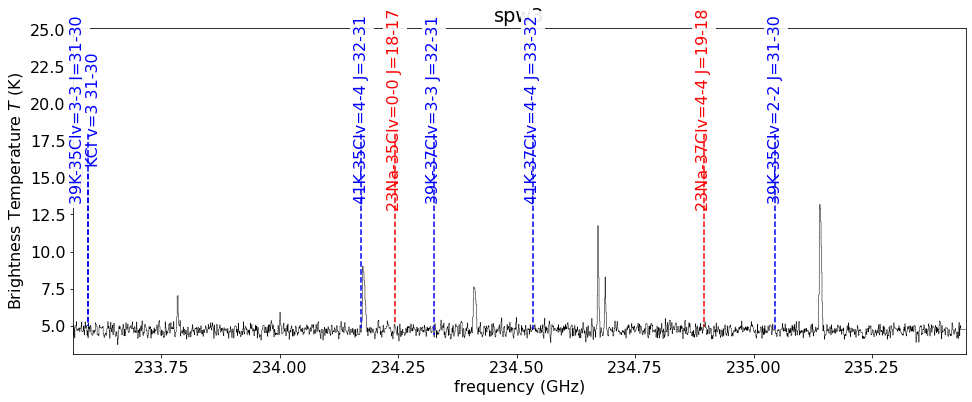

In [46]:
for fn in glob.glob('spectra/figures/color*png'):
    display(Image(fn))

IRAS_181622048.config8.spw2.robust0.5.image_co1_smaller
DaskSpectralCube with shape=(3860, 159, 173) and unit=K and chunk size (386, 159, 173):
 n_x:    173  type_x: RA---SIN  unit_x: deg    range:   274.800125 deg:  274.800636 deg
 n_y:    159  type_y: DEC--SIN  unit_y: deg    range:   -20.792144 deg:  -20.791706 deg
 n_s:   3860  type_s: FREQ      unit_s: Hz     range: 216862707361.400 Hz:218747086033.577 Hz
Mean spectrum
rms=0.3029577426765955 K
Stacking
IRAS_181622048.config8.spw1.robust0.5.image_co1_smaller
DaskSpectralCube with shape=(1930, 159, 173) and unit=K and chunk size (386, 159, 173):
 n_x:    173  type_x: RA---SIN  unit_x: deg    range:   274.800125 deg:  274.800636 deg
 n_y:    159  type_y: DEC--SIN  unit_y: deg    range:   -20.792144 deg:  -20.791706 deg
 n_s:   1930  type_s: FREQ      unit_s: Hz     range: 231062952403.500 Hz:232946842768.170 Hz


Mean spectrum
rms=0.2541047085296872 K
Stacking
IRAS_181622048.config8.spw0.robust0.5.image_co1_smaller
DaskSpectralCube with shape=(1931, 159, 173) and unit=K and chunk size (609, 159, 173):
 n_x:    173  type_x: RA---SIN  unit_x: deg    range:   274.800125 deg:  274.800636 deg
 n_y:    159  type_y: DEC--SIN  unit_y: deg    range:   -20.792144 deg:  -20.791706 deg
 n_s:   1931  type_s: FREQ      unit_s: Hz     range: 233562952559.900 Hz:235447819539.467 Hz


Mean spectrum
rms=0.271230404198885 K
Stacking
IRAS_181622048.config8.spw3.robust0.5.image_co1_smaller
DaskSpectralCube with shape=(3860, 159, 173) and unit=K and chunk size (386, 159, 173):
 n_x:    173  type_x: RA---SIN  unit_x: deg    range:   274.800125 deg:  274.800636 deg
 n_y:    159  type_y: DEC--SIN  unit_y: deg    range:   -20.792144 deg:  -20.791706 deg
 n_s:   3860  type_s: FREQ      unit_s: Hz     range: 219062707499.000 Hz:220947086171.413 Hz
Mean spectrum
rms=0.34316395925971244 K
Stacking


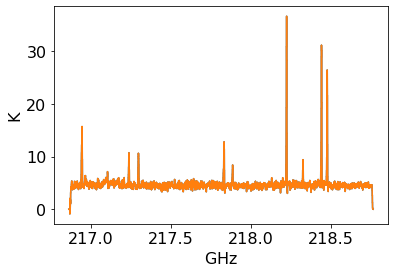

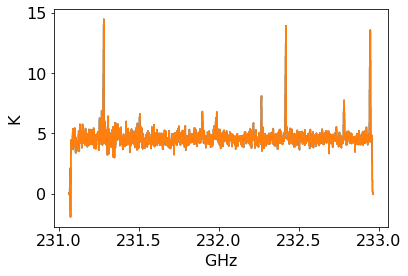

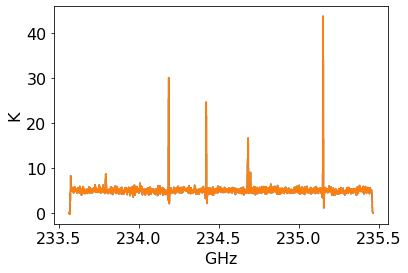

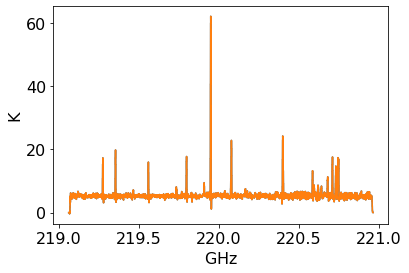

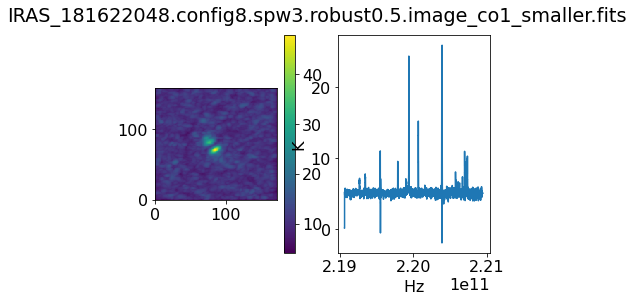

In [47]:
import glob
import spectral_cube.analysis_utilities
import reproject
from tqdm.notebook import tqdm
from astropy import stats

cbflist = (glob.glob(f'{targetname}.config8.spw[0-3].robust0.5.image_co1_smaller.fits'))
for fn in cbflist:
    basename = os.path.split(fn)[-1].split(".fits")[0]
    print(basename)
    try:
        cube = SpectralCube.read(fn, use_dask=True)
    except Exception as ex:
        print(ex)
        continue
    print(cube)
    scube = cube.subcube_from_regions(reg)
    scube.allow_huge_operations=True
    # continuum subtract before stacking
    scube = scube - scube.percentile(25, axis=0)
    #mx = scube.max(axis=0)
    #msk = mx > 0.003*mx.unit
    print("Mean spectrum")
    sp = scube.mean(axis=(1,2))
    rms = stats.mad_std(sp)
    print(f"rms={rms}")
    
    sp.write(f'spectra/{fn.split("/")[-1].replace(".fits","_meanspec.fits")}', overwrite=True)


    # reproject the velocity map into the cube's coordinate system
    vmap_proj,_ = reproject.reproject_interp(vmap,
                                             scube.wcs.celestial,
                                             shape_out=scube.shape[1:])
    vmap_proj = u.Quantity(vmap_proj, u.km/u.s)

    # convert to km/s with arbitrary rest value so 0 km/s can be interpreted
    if scube.spectral_axis.unit.is_equivalent(u.Hz):
        scube = scube.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=scube.spectral_axis.mean())

    print("Stacking")
    # perform the stacking!
    stack = spectral_cube.analysis_utilities.stack_spectra(scube, vmap_proj,
                                                           v0=0.0*u.km/u.s,
                                                           #progressbar=tqdm,
                                                           #num_cores=8
                                                          )
    fstack = stack.with_spectral_unit(u.GHz)

    pl.suptitle(f"{fn}")
    fstack.write(f'spectra/{basename}_stack.fits', overwrite=True)

    pl.clf()
    fstack.quicklook(filename=f'spectra/figures/{basename}_stack.pdf')
    fstack.quicklook(filename=f'spectra/figures/{basename}_stack.png')
    
    
    fig = pl.figure()
    mappable = pl.subplot(1,2,1).imshow(mx.value, origin='lower', interpolation='none')
    pl.colorbar(mappable)
    pl.subplot(1,2,2)
    pl.suptitle(fn)
    sp.quicklook()

In [48]:
ls spectra

figures/
IRAS_181622048.config8.spw0.robust0.5.image_co1_smaller_meanspec.fits
IRAS_181622048.config8.spw0.robust0.5.image_co1_smaller_stack.fits
IRAS_181622048.config8.spw1.robust0.5.image_co1_smaller_meanspec.fits
IRAS_181622048.config8.spw1.robust0.5.image_co1_smaller_stack.fits
IRAS_181622048.config8.spw2.robust0.5.image_co1_smaller_meanspec.fits
IRAS_181622048.config8.spw2.robust0.5.image_co1_smaller_stack.fits
IRAS_181622048.config8.spw3.robust0.5.image_co1_smaller_meanspec.fits
IRAS_181622048.config8.spw3.robust0.5.image_co1_smaller_stack.fits


In [49]:
stackspectra = []
for ii,fn in enumerate(glob.glob('spectra/*_stack.fits')):
    pysp = pyspeckit.Spectrum(fn)
    basename = os.path.basename(fn)
    spl = basename.split(".")
    pysp.specname = f'{spl[0]}_{spl[4]}_stack'
    stackspectra.append(pysp)

IRAS_181622048_5_stack
IRAS_181622048_5_stack
IRAS_181622048_5_stack
IRAS_181622048_5_stack


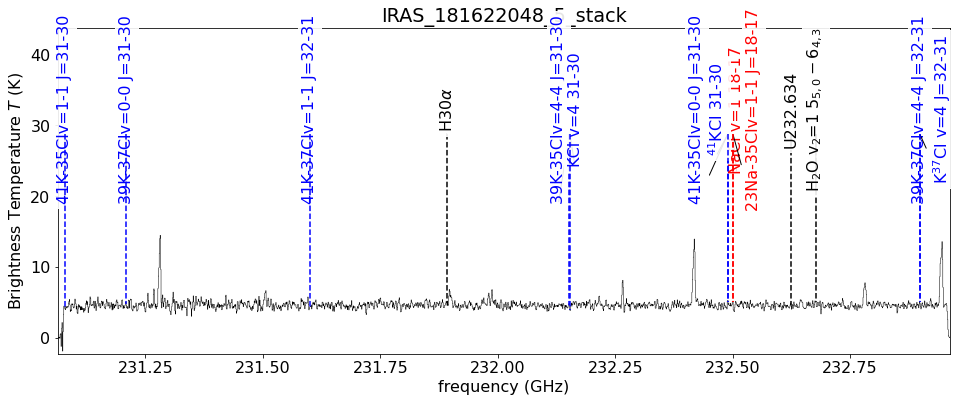

In [50]:
overplot_saltlines(stackspectra, vcen=vcen, savepath='spectra/figures')

In [51]:
ls spectra/figures/

color_labels_IRAS_181622048_5_stack.png
color_labels_spw1.png
color_labels_spw2.png
color_labels_spw3.png
color_labels_spw4.png
IRAS_181622048_5_stack.png
IRAS_181622048.config8.spw0.robust0.5.image_co1_smaller_stack.pdf
IRAS_181622048.config8.spw0.robust0.5.image_co1_smaller_stack.png
IRAS_181622048.config8.spw1.robust0.5.image_co1_smaller_stack.pdf
IRAS_181622048.config8.spw1.robust0.5.image_co1_smaller_stack.png
IRAS_181622048.config8.spw2.robust0.5.image_co1_smaller_stack.pdf
IRAS_181622048.config8.spw2.robust0.5.image_co1_smaller_stack.png
IRAS_181622048.config8.spw3.robust0.5.image_co1_smaller_stack.pdf
IRAS_181622048.config8.spw3.robust0.5.image_co1_smaller_stack.png
spw1.png
spw2.png
spw3.png
spw4.png


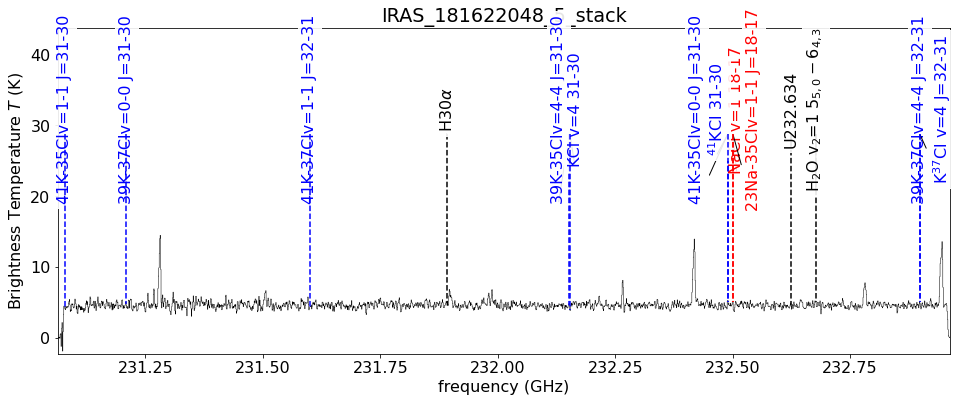

In [52]:
for fn in glob.glob('spectra/figures/color*stack.png'):
    display(Image(fn))